# 1) Data Wrangling
In this section, we familiarize ourselves with the data, perform necessary cleaning, and create a resampled dataset with a balanced target distribution. Additionally, we ensure that variables demonstrate statistical significance in relation to the target variable.

In [1]:
import time
import numpy as np
import pandas as pd

## Overview
The dataset under analysis contains a large number of entries and exhibits an imbalanced distribution of the target variable, 'Response'. There are no missing values or duplicate records within the dataset. Initial data cleaning procedures are conducted in this subsection to enhance data quality. Descriptive statistics are provided to offer a comprehensive overview of the dataset, followed by some essential metadata.

In [2]:
%%time
train = pd.read_csv('/home/petewojtczak/Desktop/auto_insurance_clf/train.csv')
test = pd.read_csv('/home/petewojtczak/Desktop/auto_insurance_clf/test.csv')

CPU times: user 10.5 s, sys: 1.07 s, total: 11.5 s
Wall time: 11.5 s


In [3]:
train.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0


In [4]:
test.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271


In [5]:
# basic dataframes info
train.shape, test.shape, train.isnull().values.any(), test.isnull().values.any(), train.duplicated().sum(), test.duplicated().sum()

((11504798, 12), (7669866, 11), False, False, 0, 0)

In [6]:
# imbalanced target variable
train.Response.value_counts(normalize=True)

0    0.877003
1    0.122997
Name: Response, dtype: float64

In [7]:
# descriptive statistics
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000
mean,5752398.500,38.384,0.998,26.419,0.463,30461.370,112.425,163.898,0.123
std,3321149.255,14.993,0.044,12.992,0.499,16454.745,54.036,79.980,0.328
min,0.000,20.000,0.000,0.000,0.000,2630.000,1.000,10.000,0.000
25%,2876199.250,24.000,1.000,15.000,0.000,25277.000,29.000,99.000,0.000
50%,5752398.500,36.000,1.000,28.000,0.000,31824.000,151.000,166.000,0.000
75%,8628597.750,49.000,1.000,35.000,1.000,39451.000,152.000,232.000,0.000
max,11504797.000,85.000,1.000,52.000,1.000,540165.000,163.000,299.000,1.000


In [8]:
def features_info(df):
    # features' metadata for a given df
    feature_info = {
        'feature': df.columns,
        'dtype': [df[col].dtype for col in df.columns],
        'unique_val': [df[col].nunique() for col in df.columns]}
    features_df = pd.DataFrame(feature_info)
    features_df.set_index('feature', inplace=True)
    features_df.sort_values(by='unique_val', ascending=False, inplace=True)
    return features_df

features_info(train)

,dtype,unique_val
feature,,
id,int64,11504798
Annual_Premium,float64,51728
Vintage,int64,290
Policy_Sales_Channel,float64,152
Age,int64,66
Region_Code,float64,54
Vehicle_Age,object,3
Gender,object,2
Driving_License,int64,2


## Cleaning
Some essential cleaning conclusions are drawn and applied here.

In [9]:
train.Region_Code.value_counts().tail(2)

51.000    1880
39.200       1
Name: Region_Code, dtype: int64

In [10]:
train = train.drop(index=train[train.Region_Code==39.2].index)

In [11]:
# data cleaning
def data_clean(raw_data):
    # returns raw_data as clean as we want it 
    raw_data.set_index('id', inplace=True)
    # according to 'train.describe()' this feature is invariant
    raw_data.drop(columns=['Driving_License'], inplace=True)
    # according to 'features_info(train)' this feature is nominal
    raw_data.Previously_Insured = raw_data.Previously_Insured.astype(str)    
    return raw_data

data_clean(train)

,Gender,Age,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,
0,Male,21,35.000,0,1-2 Year,Yes,65101.000,124.000,187,0
1,Male,43,28.000,0,> 2 Years,Yes,58911.000,26.000,288,1
2,Female,25,14.000,1,< 1 Year,No,38043.000,152.000,254,0
3,Female,35,1.000,0,1-2 Year,Yes,2630.000,156.000,76,0
4,Female,36,15.000,1,1-2 Year,No,31951.000,152.000,294,0
...,...,...,...,...,...,...,...,...,...,...
11504793,Male,48,6.000,0,1-2 Year,Yes,27412.000,26.000,218,0
11504794,Female,26,36.000,0,< 1 Year,Yes,29509.000,152.000,115,1
11504795,Female,29,32.000,1,< 1 Year,No,2630.000,152.000,189,0


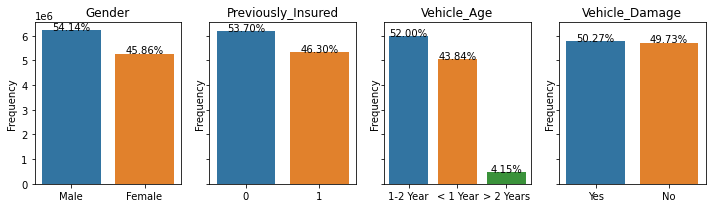

CPU times: user 19 s, sys: 1.24 s, total: 20.2 s
Wall time: 20 s


In [12]:
%%time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# nominal features frequency check
fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharey=True)

for ax, feature in zip(axes, train.select_dtypes(include='object').columns):
    sns.countplot(x=feature, data=train, ax=ax, order=train[feature].value_counts().index)
    total = len(train[feature])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.1, f'{height/total:.2%}', ha='center')

for ax, feature in zip(axes, train.select_dtypes(include='object').columns):
    ax.set_title(f'{feature}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Sampling
In this subsection, a dataframe named _df_train_ is constructed from the original data to achieve a balanced distribution of the target variable.

In [13]:
# rebalanced dataset df_train
train_1 = train[train.Response==1]
train_0 = train[train.Response==0].sample(train_1.shape[0])
df_train = pd.concat([train_0, train_1])
print(df_train.shape)
df_train.Response.value_counts(normalize=True)

(2830118, 10)


0   0.500
1   0.500
Name: Response, dtype: float64

In [14]:
%%time
from sklearn.model_selection import train_test_split
from scipy.stats import mannwhitneyu, chi2_contingency

# train/test split
y = df_train['Response']
X = df_train.drop('Response', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df_train['Response'])
df_train = pd.concat([X_train, y_train], axis=1)

CPU times: user 2.25 s, sys: 180 ms, total: 2.43 s
Wall time: 2.42 s


## Features summary

In [15]:
%%time
features_info(X_train)

CPU times: user 1.28 s, sys: 28.2 ms, total: 1.31 s
Wall time: 1.31 s


,dtype,unique_val
feature,,
Annual_Premium,float64,44874
Vintage,int64,290
Policy_Sales_Channel,float64,147
Age,int64,66
Region_Code,float64,53
Vehicle_Age,object,3
Gender,object,2
Previously_Insured,object,2
Vehicle_Damage,object,2


In [16]:
continous_features = X_train.select_dtypes(include='float64').drop(columns=['Policy_Sales_Channel', 'Region_Code']).columns
nominal_features = X_train.select_dtypes(include='object').columns
ordinal_features =  X_train.select_dtypes(exclude='object').drop(columns=['Annual_Premium', 'Region_Code']).columns
target_encoded_feature = X_train.select_dtypes(include='float64').drop(columns=['Annual_Premium', 'Policy_Sales_Channel']).columns

print(f"continous_features: {continous_features}")
print(f"nominal_features: {nominal_features}")
print(f"ordinal_features: {ordinal_features}")
print(f"target_encoded_feature: {target_encoded_feature}")

len(continous_features)+len(target_encoded_feature)+len(nominal_features)+len(ordinal_features), X_train.shape[1]

continous_features: Index(['Annual_Premium'], dtype='object')
nominal_features: Index(['Gender', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')
ordinal_features: Index(['Age', 'Policy_Sales_Channel', 'Vintage'], dtype='object')
target_encoded_feature: Index(['Region_Code'], dtype='object')


(9, 9)

## Significance testing
'Region_Code' significance test are ommited (TargetEncoder employed in order to avoid sparse matrix).

In [17]:
%%time
numeric_features = continous_features.append(ordinal_features)
# numeric features testing
for feature in numeric_features:
    group_0 = df_train[df_train['Response']==0][feature]
    group_1 = df_train[df_train['Response']==1][feature]
    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    if p < 0.05:
        print('*Feature {} is statistically significant'.format(feature))
        
# nominal features testing
for feature in nominal_features:
    contingency_table = pd.crosstab(df_train[feature], df_train['Response'])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    if p < 0.05:
        print('+Feature {} is statistically significant'.format(feature))
print('\n')

*Feature Annual_Premium is statistically significant
*Feature Age is statistically significant
*Feature Policy_Sales_Channel is statistically significant
*Feature Vintage is statistically significant
+Feature Gender is statistically significant
+Feature Previously_Insured is statistically significant
+Feature Vehicle_Age is statistically significant
+Feature Vehicle_Damage is statistically significant


CPU times: user 3.3 s, sys: 281 ms, total: 3.58 s
Wall time: 3.56 s


# 2) ML with sklearn
This section forms the core of the notebook, where we explore and identify an optimal model that fits the data well. The approach involves drawing a small sample and conducting a grid search using several sklearn algorithms to identify a particularly effective model. The identified model will subsequently be trained on a larger dataset to further enhance its performance. Nominal features are OneHotEncoded, and ordinal features are scaled using MinMaxScaler, as typically expected. Some seemingly nominal features, such as 'Region_Code' and 'Policy_Sales_Channel', are processed in a customized manner, ensuring that no sparse matrix problems will appear. For each algo, the fitted model is stored in the 'models' dictionary.

In [18]:
# small data sample 
sample = df_train.sample(n=8800) 
df_train = df_train.drop(sample.index)
print(sample.shape)
sample.Response.value_counts(normalize=True)

(8800, 10)


1   0.500
0   0.500
Name: Response, dtype: float64

In [19]:
%%time
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, TargetEncoder
from sklearn.compose import make_column_transformer

from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

prep = make_column_transformer((StandardScaler(), continous_features),
                               (TargetEncoder(), target_encoded_feature),
                               (OneHotEncoder(drop='first'), nominal_features),
                               (MinMaxScaler(), ordinal_features))
# pipelines
pipelines = {
    'logreg': make_pipeline(prep, LogisticRegression()),
    'forest': make_pipeline(prep, RandomForestClassifier(LogisticRegression())),
    'knn': make_pipeline(prep, KNeighborsClassifier())}

# hyperspace to gridsearch
hypergrid = {
    'logreg': {
        'logisticregression__C': [1.4, 2, 2.6, 4, 5.7, 7.8],
        'logisticregression__solver': ['lbfgs', 'liblinear']
    },
    'forest': {
        'randomforestclassifier__n_estimators': [72, 96, 124, 164, 221],
        'randomforestclassifier__criterion': ['gini', 'entropy'],
        'randomforestclassifier__min_samples_leaf': [12, 18, 36, 64, 88]
    },
    'knn': {
        'kneighborsclassifier__n_neighbors': list(range(5, 51, 5)),
        'kneighborsclassifier__weights': ['uniform', 'distance']
    }}

print('Training successfully initialized.\n')

# training
models = {}
for algo, pipeline in pipelines.items():
    print('* starting training for {}...'.format(algo))
    start = time.time()
    
    model = GridSearchCV(pipeline, hypergrid[algo], cv=10, scoring='roc_auc')
    model.fit(sample.drop('Response', axis=1), sample.Response)
    models[algo] = model
    
    end = time.time()
    print('  {} model fitted. ({:.2f} s)'.format(algo, end-start))
print('\n')

Training successfully initialized.

* starting training for logreg...
  logreg model fitted. (6.65 s)
* starting training for forest...
  forest model fitted. (390.36 s)
* starting training for knn...
  knn model fitted. (14.30 s)


CPU times: user 6min 54s, sys: 14.3 s, total: 7min 8s
Wall time: 6min 51s


## ML performance summary
This subsection summarizes the predictive performance of the models stored in the models dictionary. Sensitivity, specificity, and AUC are calculated for the large testing data, X_test and y_test.

In [20]:
from sklearn.metrics import roc_auc_score, confusion_matrix

y_test_summary = pd.DataFrame()

for algo in pipelines.keys():
    y_pred = models[algo].predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    y_test_summary.loc[algo,['Sensitivity']] = round(TP/float(TP + FN), 3)
    y_test_summary.loc[algo,['Specificity']] = round(TN/float(TN + FP), 3)
    y_pred = models[algo].predict_proba(X_test)[:, 1]
    y_test_summary.loc[algo,['AUC']] = roc_auc_score(y_test, y_pred)

print('Predictions perspectives (sklearn algos):')
y_test_summary.sort_values(by='AUC', ascending=False)

Predictions perspectives (sklearn algos):


,Sensitivity,Specificity,AUC
forest,0.921,0.679,0.854
logreg,0.959,0.611,0.843
knn,0.920,0.661,0.835


# 3) Best model
Here, we refit the best model identified in the previous ML section using our largest, balanced training dataset, namely X_train and y_train. Subsequently, X_test and y_test are employed to evaluate the performance of our final best model. This evaluation includes the calculation of sensitivity and specificity, the plotting of a confusion matrix, and, importantly, the assessment of our primary metric in this analysis: the Area Under the Curve (AUC).

In [21]:
models['forest'].best_params_

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__min_samples_leaf': 12,
 'randomforestclassifier__n_estimators': 164}

## Best model refit

In [22]:
%%time
best_params = models['forest'].best_params_

prep = make_column_transformer((StandardScaler(), continous_features),
                               (TargetEncoder(), target_encoded_feature),
                               (OneHotEncoder(drop='first'), nominal_features),
                               (MinMaxScaler(), ordinal_features))

pipe = make_pipeline(prep, RandomForestClassifier(n_estimators = models['forest'].best_params_['randomforestclassifier__n_estimators'],
                                                  criterion = models['forest'].best_params_['randomforestclassifier__criterion'],
                                                  min_samples_leaf = models['forest'].best_params_['randomforestclassifier__min_samples_leaf']))

pipe.fit(X_train, y_train)

CPU times: user 8min 52s, sys: 1.55 s, total: 8min 54s
Wall time: 8min 54s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['Annual_Premium'], dtype='object')),
                                                 ('targetencoder',
                                                  TargetEncoder(),
                                                  Index(['Region_Code'], dtype='object')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Gender', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  Index(['Age', 'Policy_Sales_Channel', 'Vintage'], dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=12,
                                        n_estimators=164))])

## Best model evaluation

Sensitivity: 0.93, Specificity: 0.683, Precision: 0.746


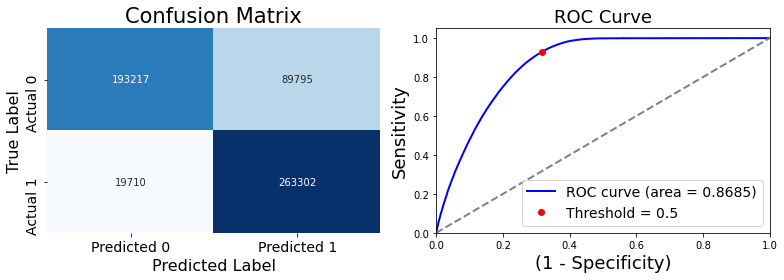

CPU times: user 45.8 s, sys: 172 ms, total: 45.9 s
Wall time: 45.8 s


In [23]:
%%time
cm = confusion_matrix(y_test, pipe.predict(X_test))
TN, FP, FN, TP = cm.ravel()

# sensitivity / specificity / precision
Sensitivity = round(TP/float(TP + FN), 3)
Specificity = round(TN/float(TN + FP), 3)
Precision = round(TP/float(TP + FP), 3)
print('Sensitivity: {}, Specificity: {}, Precision: {}'.format(Sensitivity, Specificity, Precision))

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AOC
y_pred_proba = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Confusion Matrix subplot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'], cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=21)
axes[0].set_xlabel('Predicted Label', fontsize=16)
axes[0].set_ylabel('True Label', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=14)

# ROC Curve subplot
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('(1 - Specificity)', fontsize=18)
axes[1].set_ylabel('Sensitivity', fontsize=18)
axes[1].set_title('ROC Curve', fontsize=18)
axes[1].legend(loc="lower right", fontsize=14)

default_threshold_index = np.where(thresholds > 0.5)[0][-1]
axes[1].plot(fpr[default_threshold_index], tpr[default_threshold_index], 'ro', label='Threshold = 0.5')
axes[1].legend(loc="lower right", fontsize=14)

# Show the figure
plt.tight_layout()
plt.show()

# 4) Submission

In [24]:
%%time
test = pd.read_csv('/home/petewojtczak/Desktop/auto_insurance_clf/test.csv')

y_hat = pipe.predict_proba(data_clean(test))[:, 1]
submission = pd.DataFrame(test.reset_index().id).assign(Response=y_hat)
submission

CPU times: user 4min 30s, sys: 2.8 s, total: 4min 33s
Wall time: 4min 33s


,id,Response
0,11504798,0.101
1,11504799,0.778
2,11504800,0.675
3,11504801,0.000
4,11504802,0.226
...,...,...
7669861,19174659,0.569
7669862,19174660,0.001
7669863,19174661,0.000
7669864,19174662,0.864


In [25]:
submission.to_csv('sub.csv', index=False)